# Comparison of FastPM against Dormand-Prince's 5/4 solver



In [1]:
%pylab inline
import fastpm
from nbodykit.lab import *
from nbodykit.cosmology import Cosmology, EHPower
from pmesh.pm import ParticleMesh
from fastpm.core import Solver as Solver
from fastpm.core import leapfrog
import fastpm.force.lpt as fpmops
from astropy.cosmology import Planck15
import astropy.units as u

Populating the interactive namespace from numpy and matplotlib


In [2]:
nc = 128 # Number of cells
bs = 128 # Box size in Mpc/h
a0 = 0.1 # LPT initialisation 

# Create FastPM cosmology
cosmo = Cosmology.from_astropy(Planck15.clone(m_nu=0 * u.eV))

# Initialize FastPM
pm = ParticleMesh(BoxSize=bs, Nmesh=[nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)

# Generate initial state with fastpm
whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v: cosmo.get_pklin(
  sum(ki**2 for ki in k)**0.5, 0)**0.5 * v / v.BoxSize.prod()**0.5)

<ipython-input-2-b5ebd57e170a>:13: DeprecationWarning: mode argument is deprecated, use type
  whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
<ipython-input-2-b5ebd57e170a>:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum(ki**2 for ki in k)**0.5, 0)**0.5 * v / v.BoxSize.prod()**0.5)


## Running FastPM

In [185]:
stages = np.linspace(a0, 1.0, 14, endpoint=True) 

solver = Solver(pm, cosmo, B=1)
statelpt = solver.lpt(lineark, grid, a0, order=2)
finalstate = solver.nbody(statelpt.copy(), leapfrog(stages))
final_cube_14step = pm.paint(finalstate.X)

In [186]:
stages = np.linspace(a0, 1.0, 22, endpoint=True)

solver = Solver(pm, cosmo, B=1)
statelpt = solver.lpt(lineark, grid, a0, order=2)
finalstate = solver.nbody(statelpt.copy(), leapfrog(stages))
final_cube_22step = pm.paint(finalstate.X)

In [187]:
stages = np.linspace(a0, 1.0, 42, endpoint=True)

solver = Solver(pm, cosmo, B=1)
statelpt = solver.lpt(lineark, grid, a0, order=2)
finalstate = solver.nbody(statelpt.copy(), leapfrog(stages))
final_cube_42step = pm.paint(finalstate.X)

In [160]:
stages = np.linspace(a0, 1.0, 100, endpoint=True) # 100 steps FastPM

solver = Solver(pm, cosmo, B=1)
statelpt = solver.lpt(lineark, grid, a0, order=2)
finalstate = solver.nbody(statelpt.copy(), leapfrog(stages))
final_cube_100step = pm.paint(finalstate.X)

In [188]:
Pk14 = FFTPower(final_cube_14step, mode='1d', dk=0.01, kmin=0.1).power
Pk22 = FFTPower(final_cube_22step, mode='1d', dk=0.01, kmin=0.1).power
Pk42 = FFTPower(final_cube_42step, mode='1d', dk=0.01, kmin=0.1).power
Pk100 = FFTPower(final_cube_100step, mode='1d', dk=0.01, kmin=0.1).power

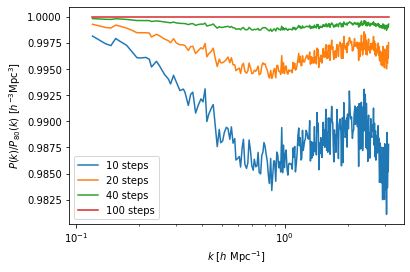

In [189]:
plt.semilogx(Pk14['k'], Pk14['power'].real/Pk100['power'].real, label='10 steps')
plt.semilogx(Pk22['k'], Pk22['power'].real/Pk100['power'].real, label='20 steps')
plt.semilogx(Pk42['k'], Pk42['power'].real/Pk100['power'].real, label='40 steps')
plt.semilogx(Pk100['k'], Pk100['power'].real/Pk100['power'].real, label='100 steps')

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)/P_{80}(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
legend()

## Runing JaxPM

In [190]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc

from diffrax import diffeqsolve, ODETerm, Dopri5, PIDController

from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field, lpt, make_ode_fn

# Resetting initial conditions
solver = Solver(pm, cosmo, B=1)
statelpt = solver.lpt(lineark, grid, a0, order=2)

mesh_shape= [nc]*3
box_size  = [bs]*3
stages = jnp.linspace(a0, 1., 2)

In [192]:
# Evolve the simulation forward using diffrax
ode_fn = make_ode_fn(mesh_shape)
term = ODETerm(lambda t, state, args: jnp.stack(ode_fn(state, t, args), axis=0))
solver = Dopri5()

stepsize_controller = PIDController(rtol=1e-4, atol=1e-4)
solution_1e4 = diffeqsolve(term, solver, t0=a0, t1=1., dt0=0.01, y0=jnp.stack([statelpt.X, statelpt.P],axis=0), 
                       args=jc.Planck15(),
                       stepsize_controller=stepsize_controller)

stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
solution_1e5 = diffeqsolve(term, solver, t0=a0, t1=1., dt0=0.01, y0=jnp.stack([statelpt.X, statelpt.P],axis=0), 
                       args=jc.Planck15(),
                       stepsize_controller=stepsize_controller)

stepsize_controller = PIDController(rtol=1e-6, atol=1e-6)
solution_1e6 = diffeqsolve(term, solver, t0=a0, t1=1., dt0=0.01, y0=jnp.stack([statelpt.X, statelpt.P],axis=0), 
                       args=jc.Planck15(),
                       stepsize_controller=stepsize_controller)

In [193]:
solution_1e6.stats, solution_1e5.stats, solution_1e4.stats

({'compiled_num_steps': None,
  'max_steps': 4096,
  'num_accepted_steps': DeviceArray(44, dtype=int32, weak_type=True),
  'num_rejected_steps': DeviceArray(3, dtype=int32, weak_type=True),
  'num_steps': DeviceArray(47, dtype=int32, weak_type=True)},
 {'compiled_num_steps': None,
  'max_steps': 4096,
  'num_accepted_steps': DeviceArray(22, dtype=int32, weak_type=True),
  'num_rejected_steps': DeviceArray(3, dtype=int32, weak_type=True),
  'num_steps': DeviceArray(25, dtype=int32, weak_type=True)},
 {'compiled_num_steps': None,
  'max_steps': 4096,
  'num_accepted_steps': DeviceArray(14, dtype=int32, weak_type=True),
  'num_rejected_steps': DeviceArray(2, dtype=int32, weak_type=True),
  'num_steps': DeviceArray(16, dtype=int32, weak_type=True)})

In [194]:
final_cube_1e4 = pm.paint(solution_1e4.ys[0,0])
final_cube_1e5 = pm.paint(solution_1e5.ys[0,0])
final_cube_1e6 = pm.paint(solution_1e6.ys[0,0])

Pk_jaxpm_1e4 = FFTPower(final_cube_1e4, mode='1d', dk=0.01, kmin=0.1).power
Pk_jaxpm_1e5 = FFTPower(final_cube_1e5, mode='1d', dk=0.01, kmin=0.1).power
Pk_jaxpm_1e6 = FFTPower(final_cube_1e6, mode='1d', dk=0.01, kmin=0.1).power

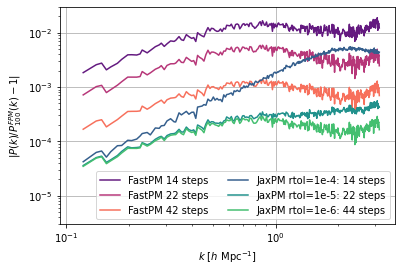

In [224]:
col = cm.magma(np.linspace(0.3,0.7,3))   
col2 = cm.viridis(np.linspace(0.3,0.7,3))   

plt.semilogx(Pk14['k'], abs(Pk14['power'].real/Pk100['power'].real - 1 ), label='FastPM 14 steps', color=col[0])
plt.semilogx(Pk22['k'], abs(Pk22['power'].real/Pk100['power'].real - 1 ), label='FastPM 22 steps', color=col[1])
plt.semilogx(Pk42['k'], abs(Pk42['power'].real/Pk100['power'].real - 1 ), label='FastPM 42 steps', color=col[2])
plt.semilogx(Pk_jaxpm_1e4 ['k'], abs(Pk_jaxpm_1e4['power'].real/Pk100['power'].real - 1), label='JaxPM rtol=1e-4: %d steps'%solution_1e4.stats['num_accepted_steps'], color=col2[0])
plt.semilogx(Pk_jaxpm_1e5 ['k'], abs( Pk_jaxpm_1e5['power'].real/Pk100['power'].real - 1), label='JaxPM rtol=1e-5: %d steps'%solution_1e5.stats['num_accepted_steps'], color=col2[1])
plt.semilogx(Pk_jaxpm_1e6 ['k'], abs( Pk_jaxpm_1e6['power'].real/Pk100['power'].real - 1), label='JaxPM rtol=1e-6: %d steps'%solution_1e6.stats['num_accepted_steps'], color=col2[2])

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$| P(k)/P^{FPM}_{100}(k) - 1 |$")
plt.grid(True)
plt.yscale('log')
legend()
plt.legend(ncol=2)
plt.ylim(3e-6, 3e-2)
plt.savefig('../figures/FastPMvsDopri.pdf',bbox_inches='tight')